#Trainig GNN
Those models were took from the 10th lab of PMLDL innopolis course where we trained to GNN to compare on the MovieLens dataset. Here I just repeat the process to see the result, so I can use the better model in the next notebook for inference - trying to suggest new movie to a user

In [114]:
!pip install torch_geometric

In [115]:
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as s

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [117]:
torch.manual_seed(69)

In [118]:
# Load the MovieLens 100k dataset
url_ratings = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns_ratings = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(url_ratings, sep='\t', names=columns_ratings)

In [119]:
# How many ratings are a 3 or above?
df = df[df['rating']>=4]
print(len(df))

55375


In [120]:
# What's the distribution of highly rated movies?
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
4    34174
5    21201
Name: rating, dtype: int64

In [121]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [122]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  44300
Test Size :  11075


In [123]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [124]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['item_id'].isin(train_item_ids))
]
print(len(test))

942 1407
11075


In [125]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [126]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  942
Number of unique Items :  1407


In [127]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([126, 142, 354, 361, 362, 382, 458, 461, 504, 538, 568, 590, 623, 706,
         736, 901], device='cuda:0'),
 tensor([1003, 1264, 1296, 1251, 1161, 1063, 1792, 1259, 1060, 1063, 1176, 1225,
         1225, 1243,  948, 1118], device='cuda:0'),
 tensor([1677, 1255, 1469, 1814, 1770, 1988, 2284, 1248, 1208, 1390, 1747, 1522,
         2148, 1794, 1219, 2089], device='cuda:0'))

In [128]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 764,  905,  333,  ..., 1115,  948, 1032],
        [1121, 1668, 1468,  ...,  248,  865,   93]], device='cuda:0')

In [129]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([1032,   93], device='cuda:0'), tensor([ 764, 1121], device='cuda:0'))

In [130]:
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([  93, 1032], device='cuda:0'), tensor([1121,  764], device='cuda:0'))

In [131]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [132]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [133]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [134]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [135]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [168]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [137]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [138]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

### Train and eval LightGCN

In [139]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2349, 64])]


In [140]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [141]:
epoch_list = [(i+1) for i in range(EPOCHS)]

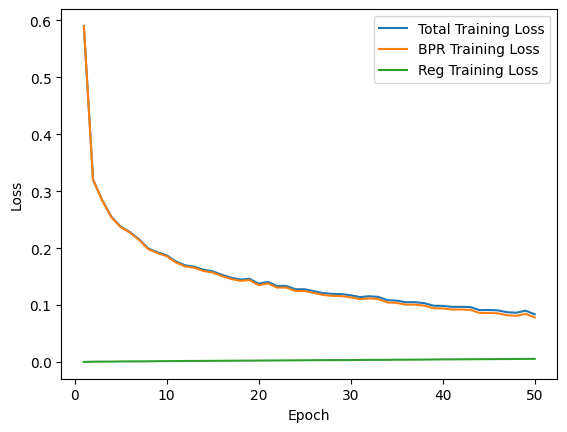

In [142]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

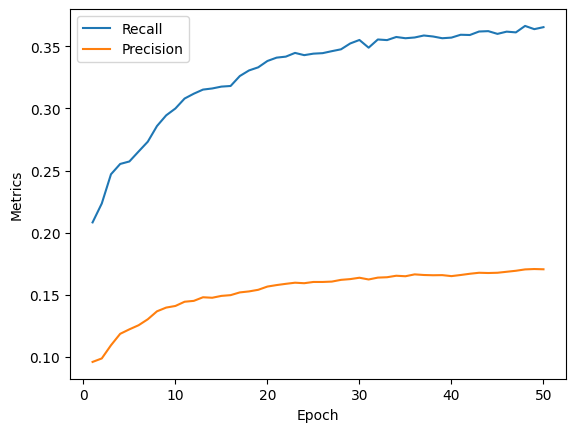

In [143]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Train and eval NGCF

In [144]:
ngcf = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([2349, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [145]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [146]:
epoch_list = [(i+1) for i in range(EPOCHS)]

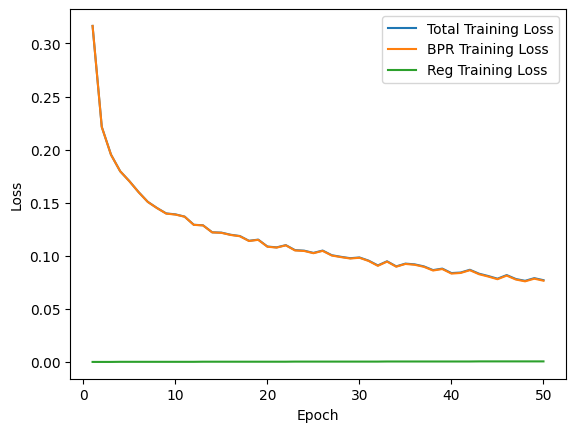

In [147]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

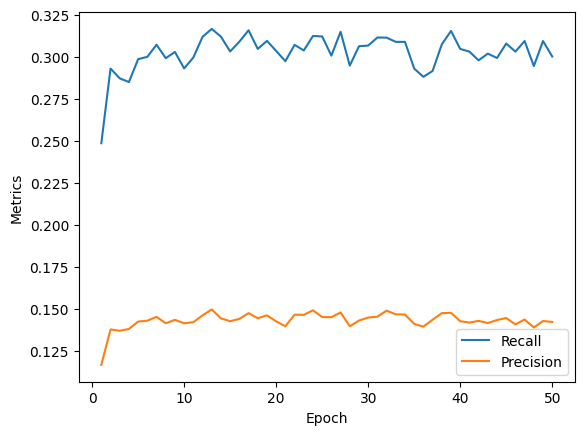

In [148]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

###Models comparison


In [149]:
max(light_precision), max(light_recall)

(0.1708, 0.3663)

In [150]:
max(ngcf_precision), max(ngcf_recall)

(0.1496, 0.3165)

#Movie prediction


In [181]:
def recomend_user(model, user_id):
    model.eval()
    with torch.no_grad():
          _, out = model(train_edge_index)

          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          #print(final_user_Embed)
          test_user_ids = torch.LongTensor(user_id)
          # compute the score of all user-item pairs
          relevance_score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
          # create dense tensor of all user-item interactions
          i = torch.stack((
            torch.LongTensor(train_df['user_id_idx'].values),
            torch.LongTensor(train_df['item_id_idx'].values)
          ))
          v = torch.ones((len(train_df)), dtype=torch.float64)
          interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
              .to_dense().to(device)
          # mask out training user-item interactions from metric computation
          relevance_score = torch.mul(relevance_score, (1 - interactions_t))
          # compute top scoring items for each user
          topk_relevance_indices = torch.topk(relevance_score, K).indices
          topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
          topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
          topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
          topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]
          return topk_relevance_indices_df.iloc[user_id]


In [183]:
def get_similar_user(user_data: dict) -> int:
    user = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u.user", sep="|", encoding='latin-1', header=None)
    user.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']

    available_occupations = set(pd.unique(user['occupation']))
    if not user_data['occupation'] in available_occupations:
        user_data['occupation'] = 'other'

    similar_users = user[(user['gender'] == user_data['gender']) & (user['occupation'] == user_data['occupation'])]
    age_diff = np.abs(similar_users['age'] - user_data['age'])

    return similar_users.iloc[np.argmin(age_diff), 0]

In [182]:
get_similar_user({'gender': 'M', 'age': 21, 'occupation': 'innopolis' })

709

In [219]:
import pandas as pd

d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')

df_movies = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u.item", sep='|',header=None,names=column_names2,encoding='latin-1')
movie_dataset = df_movies[['movie id','movie title']]


# Function to get movie name by ID
def get_movie_name(movie_id):
    movie_name = movie_dataset['movie title']
    return movie_name[movie_id-1] if len(movie_name) > 0 else None

# Example usage
movie_id = recomend_user(lightgcn, get_similar_user({'gender': 'M', 'age': 21, 'occupation': 'innopolis'}))[1][0]
movie_name = get_movie_name(movie_id)

if movie_name:
    print(f"Movie Name for ID {movie_id}: {movie_name}")
else:
    print(f"Movie with ID {movie_id} not found.")


Movie Name for ID 82: Jurassic Park (1993)
